# Exercise 1 on Clustering: Synthetic Dataset

The goal of the exercise is to perform perform clustering on a dataset representing a noisy 2D non-linear function.
* How do we select the correct number of clusters?
* Why LPCA works better than PCA on a non-linear dataset?

First thing, we create our synthetic dataset

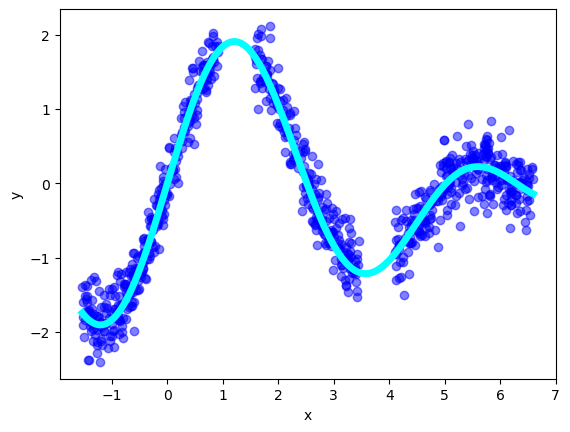

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def non_linear_func_orig(x):
    y = np.sin(x) + np.sin(1.5*x)
    return y

def non_linear_func(x):
    y = np.sin(x) + np.sin(1.5*x) + 0.25*np.random.randn(x.size) 
    return y
    
# This code is used to create our synthetic dataset
size = 1000
seed = 42
np.random.seed(seed)

x = np.random.rand(size) * 2.6*np.pi - np.pi/2
y = non_linear_func(x)

limits = [np.pi/2.5, 1.2*np.pi]
eps = np.pi/10

mask = ((x < limits[0] + eps) & (x > limits[0] - eps)) | (x < limits[1] + eps) & (x > limits[1] - eps)
x = x[~mask]
y = y[~mask]

X = np.zeros((x.size, 2))
X[:,0] = x
X[:,1] = y

x_orig = np.linspace(x.min(), x.max(), 200)
y_orig = non_linear_func_orig(x_orig)

# We can plot the dataset and the original non-linear function
plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Global PCA
Now we apply the PCA and try to reconstruct the dataset using only one dimension.
 - To do:
    - obtain X_std (dataset preprocessed with mean and STD)
    - apply PCA
    - recontruct the solution with one dimension (q=1)
        -hint: 
            - X     = Z  @ A.T
            - X_rec = Zq @ Aq.T 
    - plot the reconstruction vs the original dataset


 - hint: the documentation and examples to use the PCA object are at:
       https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


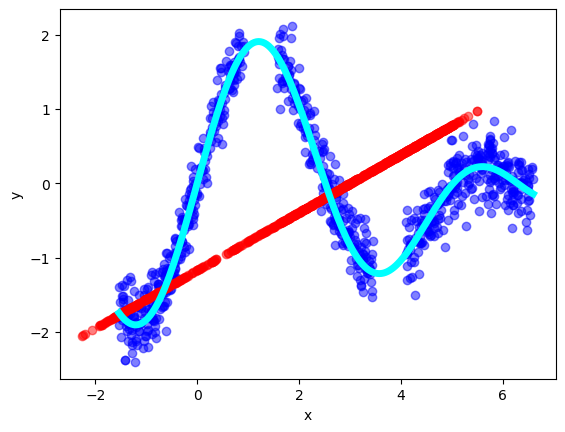

In [2]:
# We import the PCA object from the sklearn package
from sklearn.decomposition import PCA

# scale -> X_std
c = np.mean(X, axis=0) 
d = np.std (X, axis=0)

X_std = ( X - c )/ d

# Apply PCA
pca = PCA()
pca.fit(X_std)

A = pca.components_.T
Z = X_std @ A

# Reconstruct with 1 PC 
q=1
X_rec_std = Z[:,:q] @ A[:,:q].T
X_rec = X_rec_std *d + c

# plot the reconstruction VS original

plt.scatter(X[:,0], X[:,1], c='b', alpha=0.5)
plt.plot(x_orig, y_orig, c='cyan', lw=5)
plt.scatter(X_rec[:,0], X_rec[:,1], c='red', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Clustering

We can try and improve the reconstruction accuracy using a local approach. The first thing to do is then to cluster the dataset using kmeans.
- To do: 
    - Use KMeans object to obtain the cluster labels or indexes (=`idx`). init = 'random' and n_init='auto'
    - Use a number of clusters (k) of your choice.
    - Plot the dataset and colour it by the value of the label
   
   
- Hint: the documentation and examples to use the PCA object are at:
       https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

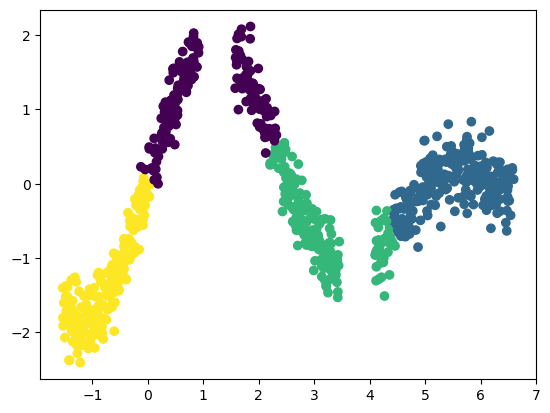

In [3]:
# We import the KMEANS object from the sklearn package
from sklearn.cluster import KMeans

# Number of clusters
k=4

# Perform KMeans
kmeans = KMeans(n_clusters=k, init='random', n_init='auto')
kmeans.fit(X)
idx = kmeans.labels_

# Plot the clustering
# Uncomment the lines below when you have calculated the clusters' labels (=idx).
plt.scatter(X[:,0], X[:,1], c=idx)
plt.show()


## Selection of the clusters' number

In this case we can visually identify the number of clusters, because we have only two dimensions. In higher dimensions, it is not possible to visualize the dataset. Also, we would prefer to have an automatic method to select the correct number of clusters.

We can use the Davies Bouldin score to estimate the number of clusters.

- To do: 
    - Calculate the DB score for a range of k (number of clusters) that goes from 2 to 10.
    - Plot the DB score as a function of k.
    - Select n_clusters based on the DB score
   
   
- Hint: 
    - the documentation and examples to use the PCA object are at:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
    - you can use a 'for' loop to calculate the DB for different k


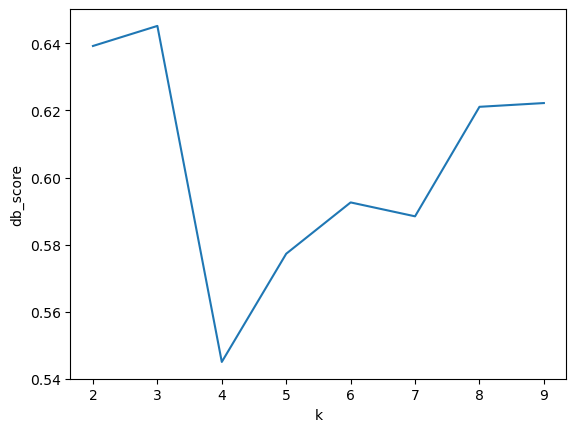

n_clusters = 4


In [4]:
from sklearn.metrics import davies_bouldin_score

# Create the k_array and the db_score_array, initiliazed with zeros
k_array         = np.arange(2,10)
db_score_array  = np.zeros((k_array.size,))

# Loop on k where: 1) perform KMeans, 2) calculate db_score and 3) stores them in db_score_array
for i,k in enumerate(k_array):
    kmeans = KMeans(n_clusters=k, init='random', n_init='auto')
    kmeans.fit(X)
    idx = kmeans.labels_
    
    db_score = davies_bouldin_score(X, idx)
    db_score_array[i] = db_score

# Plot DB score Vs n_clusters
plt.plot(k_array, db_score_array)
plt.xlabel('k')
plt.ylabel('db_score')
plt.show()

# Select n_clusters based on db_scores
index = np.argmin(db_score_array)
n_clusters = k_array[index]

print(f'n_clusters = {n_clusters}')

## Local PCA

Now we can apply the PCA in each cluster.
- To do: 
    - apply PCA for each cluster
    - plot the reconstruction using only the first PC.
- Hint:
    - Use a 'for' loop to apply the PCA in each cluster.
    - to select only the data of a single cluster use a mask:
           To select the data with label 0:
             mask = (idx == 0)
             X_k = X[mask]
    - To get the correct reconstruction, you need to **center and scale** the data **in each cluster** before applying the PCA, and then de-center and de-scale the data

 k = 0
 k = 1
 k = 2
 k = 3


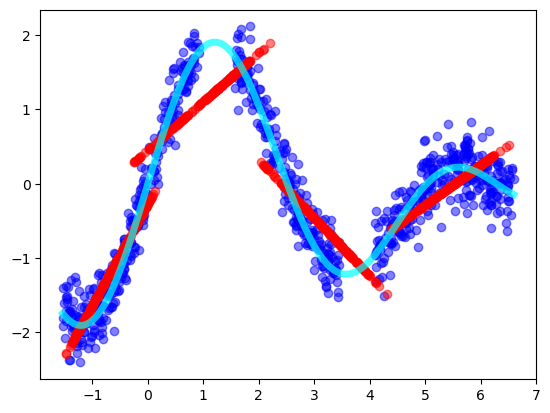

In [10]:
# We compute Kmeans with the correct number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='random', n_init='auto')
kmeans.fit(X)
idx = kmeans.labels_            

q = 1

# We create the PCA object
pca = PCA()

# Loop on clusters:
for k in range(n_clusters):
    print(f' k = {k}')
    
    # create the mask: select the points belonging to cluster k
    mask = (idx==k)
    X_k  = X[mask]
    
    # center and scale X_k
    c_k  = np.mean(X_k, axis=0)
    d_k  = np.std (X_k, axis=0)
    X_std_k = (X_k - c_k )/d_k
    
    # perform the pca
    pca.fit(X_std_k)
    A_k = pca.components_.T
    Z_k = X_std_k @ A_k
    
    # recontruct and uncenter and unscale
    X_std_k_rec = Z_k[:,:q] @ A_k[:,:q].T 
    
    X_k_rec     = d_k * X_std_k_rec  + c_k
    
    # plot the reconstruction
    plt.scatter(X_k[:,0]    ,X_k[:,1],     c='b', alpha=0.5)
    plt.scatter(X_k_rec[:,0],X_k_rec[:,1], c='r', alpha=0.5)

plt.plot(x_orig, y_orig, c='cyan', lw=5, alpha=0.7)
plt.show()

## Local PCA with VQPCA

We can compare the KMEANS results with VQPCA. To perform VQPCA, we need the [OpenMORe](https://github.com/burn-research/OpenMORe) library. You can run the next cell to install it. 

In [11]:
!git clone https://github.com/burn-research/OpenMORe.git

import sys

sys.path.insert(0,'/content/OpenMORe')

import OpenMORe

Cloning into 'OpenMORe'...
remote: Enumerating objects: 1444, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1444 (delta 135), reused 142 (delta 65), pack-reused 1222
Receiving objects: 100% (1444/1444), 16.37 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (1020/1020), done.


In [12]:
import OpenMORe.clustering as clustering

# This is a dictionary used to set the VQPCA parameters.
settings_clustering = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "uniform",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : 3,
    "number_of_eigenvectors"    : 1,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : False,    # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : True,     # --> enable the calculation of indeces to evaluate the goodness of the clustering
    "neighbors_number"          : 0,
    
    "kNN_post"                  : False,     # activate the kNN algorithm once the convergence is achieved
}

# To do: follow the example in 
# https://github.com/burn-research/OpenMORe/blob/master/examples/clustering/lpcaExample.py
# to find the vqpca labels, then plot the clusters

# First we create the model and then we fit it to the dataset
model = clustering.lpca(X, settings_clustering)
idx_vqpca = model.fit()

Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 0.5990691618683146
	Reconstruction error variance: 0.6692563457636577
- Iteration number: 2
	Reconstruction error: 0.08511235290787453
	Reconstruction error variance: 6.038568919798823
- Iteration number: 3
	Reconstruction error: 0.06111069950664303
	Reconstruction error variance: 0.39275697373783774
- Iteration number: 4
	Reconstruction error: 0.053982438613246066
	Reconstruction error variance: 0.13204777473035176
- Iteration number: 5
	Reconstruction error: 0.05027408272988217
	Reconstruction error variance: 0.0737627756092245
- Iteration number: 6
	Reconstruction error: 0.04885173538507385
	Reconstruction error variance: 0.029115595046863042
- Iteration number: 7
	Reconstruction error: 0.04790831398778249
	Reconstruction error variance: 0.019692227063802425
- Iteration number: 8
	Reconstruction error: 0.047381540554376725
	Reconstruction error variance: 0.011117693245985013
- Ite

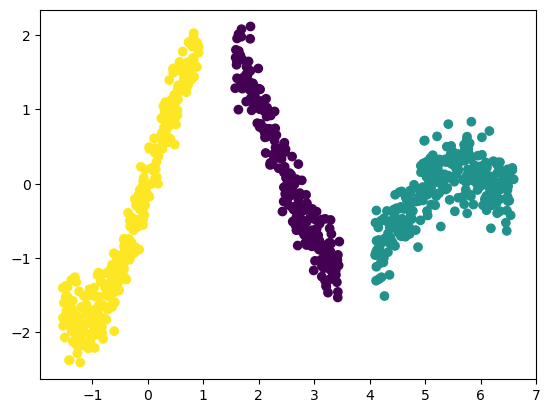

In [13]:
# Now we can plot the clusters
plt.scatter(X[:,0], X[:,1], c=idx_vqpca)
plt.show()